In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2
import pandas as pd
import numpy as np
import os
from natsort import natsorted
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Preprocess Data

## Display Image

In [3]:
def display_image(inp_tensor, img_pos=0):
    """
    img_pos of 0 will get the middle image. img_pos -1 will get the img BEFORE the middle img, 1 will get the img AFTER the middle img, and so on.
    inp_tensor will be of shape [c, h, w]
    """
    num_channels = inp_tensor.shape[0]
    num_imgs = num_channels // 3
    middle_idx = num_imgs - 1 - (num_imgs // 2)
    selected_idx = middle_idx + img_pos

    img = inp_tensor[3*selected_idx:3*selected_idx+3]
    img = torch.permute(img, (1, 2, 0))
    # img = img[:, :, [2, 1, 0]]
    plt.figure()
    # plt.imshow(img)
    plt.imshow(img.cpu().numpy())
    plt.show()

## Dataset

In [4]:
class TennisDataset(Dataset):
    def __init__(self, base_path, frames=1, resize=(360, 640), transform=None):
        self.base_path = base_path
        self.frames = frames
        self.resize = resize
        self.transform = v2.Compose([
            v2.Resize((resize[0], resize[1])),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])

        frames_ahead = frames // 2
        frames_behind = frames - 1 - frames_ahead

        data = []
        for game_name in natsorted(os.listdir(base_path)):
            game_path = os.path.join(base_path, game_name)
            if not os.path.isdir(game_path):
                continue

            for clip_name in natsorted(os.listdir(game_path)):
                clip_path = os.path.join(game_path, clip_name)
                if not os.path.isdir(clip_path):
                    continue

                # get labels, format their filenames, and combine them into one
                label_file_path = os.path.join(clip_path, 'Label.csv')
                label = pd.read_csv(label_file_path)
                label = label[frames_behind:-frames_ahead][:]
                label = label.fillna(-1)
                label = label.rename(columns={"file name": "filename"})
                label['filename'] = game_name + '_' + clip_name + '_' + label['filename']
                data.extend(label.values.tolist())

        self.labels = pd.DataFrame(data, columns=['filename', 'visibility', 'x-coordinate', 'y-coordinate', 'status'])
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        imgs = []
        label = self.labels.iloc[idx]
        
        filename = label.iloc[0]
        first_sep = filename.index("_")
        second_sep = filename.index("_", first_sep + 1)
        game_name = filename[:first_sep]
        clip_name = filename[first_sep+1:second_sep]
        img_num = int(filename[second_sep+1:filename.index(".")])

        frames_behind = self.frames - 1 - (self.frames // 2)
        start = img_num - frames_behind
        for i in range(start, start + self.frames):
            img_name = str(i).zfill(4) + ".jpg"
            img_path = os.path.join(self.base_path, game_name, clip_name, img_name)
            img = Image.open(img_path).convert('RGB')
            orig_w, orig_h = img.size
            if self.transform:
                img = self.transform(img)
            imgs.append(img)

        imgs = torch.cat(imgs, dim=0)

        # label consists of 'visibility', 'x-coordinate', 'y-coordinate', and 'status'
        label_vis = label.iloc[1]
        label_x = label.iloc[2]
        label_y = label.iloc[3]
        label_status = label.iloc[4]
        if label_x != -1:
            label_x = label_x * (self.resize[1] / orig_w)
        if label_y != -1:
            label_y = label_y * (self.resize[0] / orig_h)
        
        label = torch.tensor([label_vis, label_x, label_y, label_status], dtype=torch.float32)

        img_name = str(img_num).zfill(4) + ".jpg"
        path_gt = os.path.join(self.base_path, game_name, clip_name, img_name)
        gt_output = self.get_output(path_gt)

        return imgs, gt_output, label

    def get_output(self, path_gt):
        img = cv2.imread(path_gt, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.resize[1], self.resize[0]))
        # img = img[:, :, 0]
        img = np.reshape(img, self.resize[1] * self.resize[0])
        return img

## Dataloader

In [5]:
from torch.utils.data import DataLoader

In [6]:
base_path = './datasets/tennis'

In [7]:
full_dataset = TennisDataset(base_path, frames=3)

In [8]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

batch_size = 2

In [9]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

In [10]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

## Model

In [11]:
import torch.nn as nn

In [12]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.block(x)
        return x

class TrackNet(torch.nn.Module):
    def __init__(self, frames=1, out_channels=256):
        super().__init__()
        self.out_channels = out_channels
        self.VGG16 = nn.Sequential(
            ConvBlock(in_channels=frames*3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=256, out_channels=512),
            ConvBlock(in_channels=512, out_channels=512),
            ConvBlock(in_channels=512, out_channels=512)
        )
        self.DeconvNet = nn.Sequential(
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=512, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=256, out_channels=128),
            ConvBlock(in_channels=128, out_channels=128),
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=128, out_channels=64),
            ConvBlock(in_channels=64, out_channels=64),
            ConvBlock(in_channels=64, out_channels=self.out_channels)
        )
        # self.softmax = nn.Softmax(dim=1)
        
        self.init_weights()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.VGG16(x)
        x = self.DeconvNet(x)
        x = x.reshape(batch_size, self.out_channels, -1)
        return x

    # def evaltest(self, x):
    #     batch_size = x.size(0)
    #     x = self.VGG15(x)
    #     x = self.DeconvNet(x)
    #     x = self.softmax(x)
    #     return x

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                # nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

In [13]:
model = TrackNet(frames=3, out_channels=256).to(device)

C:\Users\alexr\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5070 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5070 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


## Hyperparameters

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
epochs = 50

e = 0

## Heatmap

In [15]:
def get_ball_xy(depth_indices, threshold=128):
    ret = []
    for indices in depth_indices:
        heatmap = torch.where(indices >= threshold, torch.tensor(255), torch.tensor(0))
        heatmap = torch.reshape(heatmap, (360, 640))
        heatmap = heatmap.detach().cpu().numpy()
        heatmap = heatmap.astype(np.uint8)
        circles = cv2.HoughCircles(heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=1, param1=50, param2=2, minRadius=2, maxRadius=7)
        # circles = cv2.HoughCircles(heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=1)
        x, y = None, None
        
        if circles is not None:
            x = circles[0][0][0]
            y = circles[0][0][1]
            ret.append((x, y))

    return ret
    # heatmap = torch.where(depth_indices >= threshold, torch.tensor(255), torch.tensor(0))
    # return heatmap

## Train

In [16]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    
    for iter_id, (imgs, gt_output, label) in enumerate(train_loader):
        imgs = imgs.to(device)
        gt_output = gt_output.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        gt_output = gt_output.long()
        loss = criterion(outputs, gt_output)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss / (iter_id + 1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        batch_bar.update()

    batch_bar.close()
    return running_loss / len(train_loader)

## Validate

In [21]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = []
    dist = []
    tp = [0, 0, 0, 0]
    fp = [0, 0, 0, 0]
    tn = [0, 0, 0, 0]
    fn = [0, 0, 0, 0]
    
    with torch.no_grad():
        for iter_id, (imgs, gt_output, label) in enumerate(val_loader):
            imgs = imgs.to(device)
            gt_output = gt_output.to(device)
            label = label.to(device)
            
            outputs = model(imgs)
            gt_output = gt_output.long()
            loss = criterion(outputs, gt_output)
            running_loss.append(loss.item())
            
            softmax_layers = nn.Softmax(dim=1)(outputs)
            depth_indices = torch.argmax(softmax_layers, dim=1)

            circles = get_ball_xy(depth_indices, threshold=128)
            for idx, (x, y) in enumerate(circles):
                visibility = int(label[idx][0].item())
                x_coord = label[idx][1].item()
                y_coord = label[idx][2].item()
                status = int(label[idx][3].item())

                if not x or not y:
                    if visibility == 0.0:
                        tn[visibility] += 1
                    else:
                        fn[visibility] += 1
                else:
                    if visibility == 0.0:
                        fp[visibility] += 1
                    else:
                        tp[visibility] += 1
                        x_dist = (x_coord - x)**2
                        y_dist = (y_coord - y)**2
                        dist.append(np.sqrt(x_dist + y_dist))
                        # dist.append(np.linalg.norm((x_coord, y_coord) - (x, y)))
            
            # print(depth_indices.shape)
    return np.mean(running_loss), np.mean(dist), tp, fp, tn, fn
            

In [37]:
features, gt_output, labels = next(iter(train_dataloader))

In [38]:
i = 0

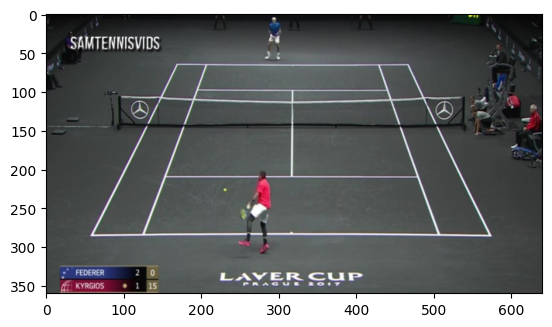

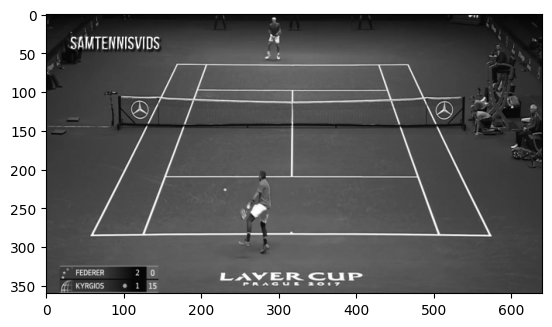

tensor([  1.0000, 231.5000, 227.5000,   0.0000])


In [39]:
display_image(features[i])

gt = torch.reshape(gt_output[i], (360, 640))
plt.imshow(gt, cmap='gray')
plt.show()

print(labels[i])

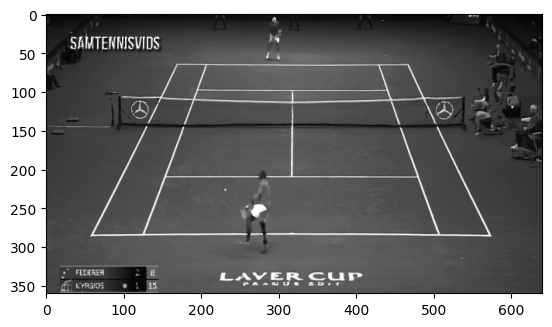

In [40]:
model.eval()
with torch.no_grad():
    imgs = features.to(device)
    gt = gt_output.to(device)
    label = labels.to(device)

    outputs = model(imgs)

    softmax_layers = nn.Softmax(dim=1)(outputs)
    depth_indices = torch.argmax(softmax_layers, dim=1)

    depth_indices_second = depth_indices[i]
    second_reshaped = torch.reshape(depth_indices_second, (360, 640)).detach().cpu().numpy()
    plt.imshow(second_reshaped, cmap='gray')

In [41]:
threshold = 128

In [42]:
heatmap = torch.where(depth_indices_second >= threshold, torch.tensor(255), torch.tensor(0))
heatmap = torch.reshape(heatmap, (360, 640))

# ret, heatmap = cv2.threshold(heatmap, 127, 255, cv2.THRESH_BINARY)
# heatmap = heatmap.reshape((360, 640))

In [43]:
heatmap = heatmap.detach().cpu().numpy()

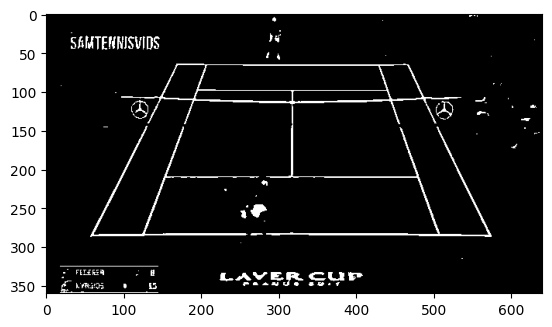

In [44]:
plt.imshow(heatmap, cmap='gray');

In [ ]:
heatmap = heatmap.astype(np.uint8)

In [ ]:
circles = cv2.HoughCircles(image=heatmap, method=cv2.HOUGH_GRADIENT, 
                          dp=1, minDist=50, param1=50, param2=2,
                          minRadius=1, maxRadius=5)

In [ ]:
# circles = np.uint16(np.around(circles))
print(circles.shape)

In [ ]:
circles = np.uint16(np.around(circles))

# for i in circles[0, :]:
    # cv2.circle(heatmap, (i[0], i[1]), i[2], (0, 255, 0), 2)
    # cv2.circle(heatmap, (i[0], i[1]), 2, (0, 0, 255), 3)

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(heatmap, cmap='gray')

for i in circles[0, :]:
    c = plt.Circle((i[0], i[1]), i[2], color='g', fill=False)
    ax.add_patch(c)

plt.show()

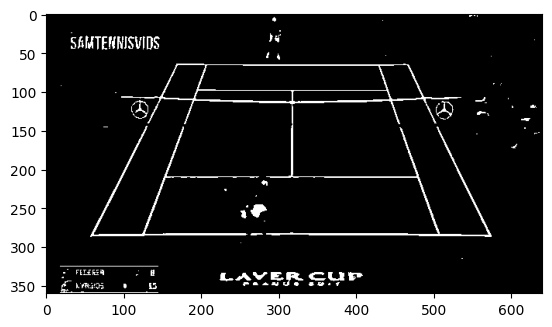

In [145]:
plt.imshow(heatmap, cmap='gray');

In [146]:
heatmap = heatmap.astype(np.uint8)

In [147]:
blurred_heatmap = cv2.GaussianBlur(heatmap, (7, 7), 1.5)

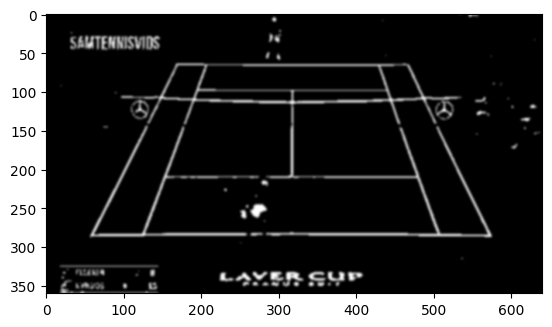

In [151]:
plt.imshow(blurred_heatmap, cmap='gray')

In [172]:
circles = cv2.HoughCircles(image=blurred_heatmap, method=cv2.HOUGH_GRADIENT,
                          dp=1, minDist=10, param1=50, param2=5,
                          minRadius=1, maxRadius=5)

In [173]:
print(circles.shape)

(1, 117, 3)


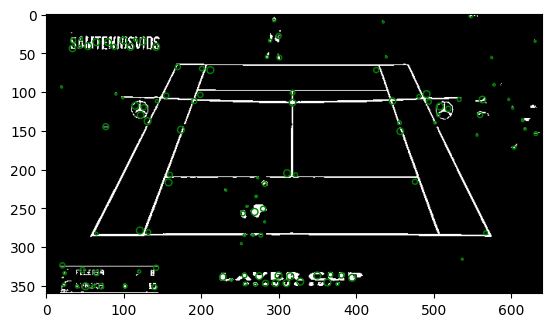

In [174]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(heatmap, cmap='gray')

# circle_idx = 3
# c = plt.Circle((circles[0, circle_idx, 0], circles[0, circle_idx, 1]), 
#                circles[0, circle_idx, 2], color='g', fill=False)
# ax.add_patch(c)

for i in circles[0, :]:
    c = plt.Circle((i[0], i[1]), i[2], color='g', fill=False)
    ax.add_patch(c)

plt.show()

## Training Loop

In [ ]:
best_dist = 5000.0

for epoch in range(e, epochs):
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"epoch {epoch}, training loss: {train_loss}")
    val_loss, avg_dist, tp, fp, tn, fn = validate(model, val_dataloader, criterion, device)
    # val_loss = float("{:.2f}".format(val_loss))
    # avg_dist = float("{:.2f}".format(avg_dist))
    print(f"epoch: {epoch}, val loss: {val_loss}, avg_dist: {avg_dist}")
    print(f"tp: {tp}")
    print(f"fp: {fp}")
    print(f"tn: {tn}")
    print(f"fn: {fn}")
    if avg_dist < best_dist:
        print("better model detected. saving model.")
        best_dist = avg_dist
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch
        }, 'model.pth')

## Load Model (and resume training)

In [18]:
model = TrackNet(frames=3, out_channels=256).to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)

In [19]:
checkpoint = torch.load('model.pth', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
e = checkpoint['epoch']

In [20]:
model.train();